# Reinforcement Learning | Multi-Agent RL | Self-Play | Proximal Policy Optimization Algorithm (PPO) agent | Unity Tennis environment | Collaboration and Competition

---

This repository, shows how to implement and train an actor-critic [PPO](https://arxiv.org/abs/1707.06347) (Proximal Policy Optimization) Reinforcement Learning agent to play Tennis against itself. The Unity simulation environment is called Tennis and rather similar to environments depicted [here](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md).

In this README.md you'll see how to install dependencies and run the code on your own machine. To understand the learning algorithm PPO checkout the `Tennis.ipynb` notebook.

**Why?** Reinforcement Learning (RL) is one of the most fascinating areas of Machine Learning! It is quite intuitive, because we use positive and negative feedback to learn tasks via interaction with the environment. The PPO algorithm, by Schulman et al. 2017, has been used at OpenAi to solve complex real-world tasks such as manipulating physical objects with a robot hand. Check out this [Learning Dexterity: Uncut](https://www.youtube.com/watch?time_continue=1&v=DKe8FumoD4E&feature=emb_logo) video, or the ones about simulated humanoid robots from their website [here](https://openai.com/blog/openai-baselines-ppo/) to get an idea! 

**What?** In this Tennis environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play. This is a trained agent in the environment.

<img src="imgs/tennis-self-play.gif\" width="450" align="center" title="Tennis Unity environment">

**How?** Checkout the `Tennis.ipynb` notebook to learn more about the PPO algorithm, and check the implementations in `ppo_agent.py`, `policy.py`. If you want to train an agent, or see a trained agent play tennis then `train.py`, and `watch_trained_agent.py` are the go-to files.

### 1. The Learning Algorithm

The Proximal Policy Optimization [PPO](https://arxiv.org/abs/1707.06347) algorithm was developed by Schulmann et al. in 2017 at the company [OpenAI](https://openai.com/). The abstract reads as follows: 
>We propose a new family of policy gradient methods for reinforcement learning, which alternate between sampling data through interaction with the environment, and optimizing a "surrogate" objective function using stochastic gradient ascent. Whereas standard policy gradient methods perform one gradient update per data sample, we propose a novel objective function that enables multiple epochs of minibatch updates. The new methods, which we call proximal policy optimization (PPO), have some of the benefits of trust region policy optimization (TRPO), but they are much simpler to implement, more general, and have better sample complexity (empirically). Our experiments test PPO on a collection of benchmark tasks, including simulated robotic locomotion and Atari game playing, and we show that PPO outperforms other online policy gradient methods, and overall strikes a favorable balance between sample complexity, simplicity, and wall-time.

This is the PPo algorithm (taken from [source](http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_13_advanced_pg.pdf)). 

<img src="imgs/PPO-algorithm.png" width="600" align="center" title="PPO algorithm"/>

The PPO computes a surrogate loss function (see above) without computing natural gradients and enables us to re-use previously collected trajectories from an older version of the same policy. For details please refer to the paper. In this notebook we use the following hyperparameters and model architecture. Refer to the code for more details.

- SEED = 123
- SEED = 0
- LR = 5e-4
- T_MAX_ROLLOUT = 1024
- GAMMA = 0.999
- TAU = 0.95
- K_EPOCHS = 16
- BATCH_SIZE = 64
- EPSILON_PPO = 0.2
- USE_ENTROPY = False
- ENTROPY_WEIGHT = 0.01
- GRADIENT_CLIPPING = 2 

The chosen actor critic model architecture is as follows. The actor and crtic network share the same fully connected body and have 5957 free, trainable parameters.

```python
ActorCritic(
  (fc1_body): Linear(in_features=24, out_features=64, bias=True)
  (fc2_body): Linear(in_features=64, out_features=64, bias=True)
  (fc3_actor): Linear(in_features=64, out_features=2, bias=True)
  (fc3_critic): Linear(in_features=64, out_features=1, bias=True)
)
```

### 2. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
"""
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    t = 0
    
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        t += 1
        if np.any(dones):                                  # exit loop if episode finished
            print('Espisode finished after {} time steps.'.format(t))
            break
    print('Score (max over agents) from episode {}: {:.3f}'.format(i, np.max(scores)))
env.close()
"""

"\nfor i in range(1, 6):                                      # play game for 5 episodes\n    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    \n    states = env_info.vector_observations                  # get the current state (for each agent)\n    scores = np.zeros(num_agents)                          # initialize the score (for each agent)\n    t = 0\n    \n    while True:\n        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)\n        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1\n        env_info = env.step(actions)[brain_name]           # send all actions to tne environment\n        next_states = env_info.vector_observations         # get next state (for each agent)\n        rewards = env_info.rewards                         # get reward (for each agent)\n        dones = env_info.local_done                        # see if episode finished\n        scores += env_info.rewar

### 5. Train a PPO Agent

I'd recommend that you open the files `ppo_agent.py`, and `policy.py` in different tabs and walk through the code step by step to gain a deeper understanding. Training a PPO agent from scratch to solving the environment took approximately 02:00h on a 2.7 GHz Intel Core i5 (2015). Restart the kernel and only run the code underneath. If you just want to see a trained agent playing tennis, then jump to section 6.

In [1]:
from unityagents import UnityEnvironment
from collections import deque
from ppo_agent import Agent
import numpy as np
import torch
import pandas as pd



# start unity environment
env = UnityEnvironment(file_name="Tennis.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size
number_of_agents = len(env_info.agents)

print_every = 10



def run_ppo(env, brain_name, agent, num_episodes=2000):
    scores = []
    scores_window = deque(maxlen=100)

    for i_episode in range(1, num_episodes+1):
        agent.step(env, brain_name)
        max_score = agent.act(env, brain_name)
        scores.append(max_score)
        scores_window.append(max_score)

        print('\r{}/{} Episode. Current score: {:.4f} Avg last 100 score: {:.4f}'.\
            format(i_episode, num_episodes, max_score, np.mean(scores_window)), end="")
        
        if i_episode % print_every == 0:
            print('\r{}/{} Episode. Current score: {:.4f} Avg last 100 score: {:.4f}'.\
                format(i_episode, num_episodes, max_score, np.mean(scores_window)))

        if np.mean(scores_window) > 0.5:
            agent.save()
            print('\rEnvironment solved after {} episodes. Avg last 100 score: {:.4f}'.\
                format(i_episode, np.mean(scores_window)))
            break

    return scores


print("Start Training...")
agent = Agent(state_size, action_size, load_pretrained=False)
scores = run_ppo(env, brain_name, agent)
print("\nTraining finished.")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Start Training...
Number of trainable actor critic model parameters:  5957
10/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0390
20/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0295
30/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0260
40/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0293
50/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0254
60/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0258
70/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0290
80/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0339
90/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0344
100/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0358
110/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0358
120/2000 Episode. Current score: 0.1000 Avg last 100 score: 0.0408
130/2000 Episode. Current score: 0.0000 Avg last 100 score: 0.0447
140/2000 Episode. Current score: 0.0900 Avg last 100 score: 0.0

The first time a score >= 0.5 was reached at episode 1079.
Max score reached: 2.7000


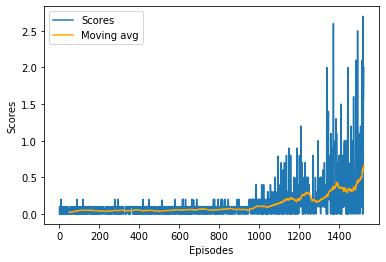

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

scores = np.array(scores)
x = np.where(scores >= 0.5)
print('The first time a score >= 0.5 was reached at episode {}.'.format(x[0][0]))
print('Max score reached: {:.4f}'.format(np.amax(scores)))

df = pd.DataFrame({
    'x': np.arange(len(scores)),
    'y': scores, 
    })
rolling_mean = df.y.rolling(window=50).mean()

#img_path ="imgs/scores_plot.png"
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(df.x, df.y, label='Scores')
plt.plot(df.x, rolling_mean, label='Moving avg', color='orange')
plt.ylabel('Scores')
plt.xlabel('Episodes')
plt.legend()
plt.show()
#fig.savefig(fname=img_path)
#print('\nPlot saved to {}.'.format(img_path))

### 6. Watch a trained Agent

Restart the kernel and run the code cell below to load a trained agent and run it in the environment.

In [1]:
import numpy as np
import torch
from unityagents import UnityEnvironment
from ppo_agent import Agent


# start unity environment
env = UnityEnvironment(file_name="Tennis.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size

agent = Agent(state_size, action_size, load_pretrained=True)
num_episodes = 2

for i_episode in range(1, num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    states1 = states[0]
    states2 = states[1]
    scores = np.zeros(2)
    agent.ac_model.eval()

    while True:
        with torch.no_grad():
            # self-play: same actor critic model is used for two players
            actions1, _, _, _ = agent.ac_model(states1)
            actions2, _, _, _ = agent.ac_model(states2)
        actions = torch.cat((actions1, actions2), dim=0)
        env_info = env.step([actions.cpu().numpy()])[brain_name]
        next_states = env_info.vector_observations
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        states1 = states[0]
        states2 = states[1]

        if np.any(dones):
            print('Episode {} finished. Scores reached: {}'.format(i_episode, scores))
            break
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of trainable actor critic model parameters:  5957
Loading pre-trained actor critic model from checkpoint.
Episode 1 finished. Scores reached: [0.70000001 0.69000001]
Episode 2 finished. Scores reached: [1.49000002 1.60000002]


### 7. Ideas for future work


To reach better results one can:

- do extensive hyper parameter search e.g. using larger T_MAX_ROLLOUT, K_EPOCHS, and BATCH_SIZE
- test the influence of the (USE_ENTROPY = True) term
- use a different model architecture with more and deeper layers, e.g. even different networks for the actor and critic
- run code on a GPU (e.g. with the headless version in the cloud)
- utilize parallel training 
- more simulation time might yield better results


### 8. Credit

This notebook is a project submission for the [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). If you are interested to learn more about Deep Reinforcement Learning, I can highly recommend it! My contribution lays mainly in section 1, 5, 6, 7, and corresponding code files: `train.py`, `ppo_agent.py`, `policy.py` , and `watch_trained_agent.py`.

Thanks and shoutout to [Jeremi Kaczmarczyk](https://github.com/jknthn), [Andrei Li](https://github.com/andreiliphd), and especially to [ShangtongZhang](https://github.com/ShangtongZhang). Parts of this code is based on their work!